In [1]:
import os
import datetime
from itertools import chain
from copy import deepcopy
import warnings

from tqdm.autonotebook import tqdm

import h5py
import pickle
import yaml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scanpy as sc
import scipy.stats as ss

import torch
from torch import nn

from src.da_models.adda import ADDAST
from src.da_models.datasets import SpotDataset
from src.da_models.utils import set_requires_grad
from src.utils.dupstdout import DupStdout
from src.utils.data_loading import (
    load_spatial,
    load_sc,
    get_selected_dir,
    get_model_rel_path,
)
from src.utils.evaluation import format_iters

script_start_time = datetime.datetime.now(datetime.timezone.utc)


/tmp/ipykernel_29306/2868717141.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
data_params = {}
# Data path and parameters
data_params["data_dir"] = "data"
data_params["train_using_all_st_samples"] = False
data_params["n_markers"] = 20
data_params["all_genes"] = False

# Pseudo-spot parameters
data_params["n_spots"] = 20000
data_params["n_mix"] = 8

# ST spot parameters
data_params["st_split"] = False
data_params["sample_id_n"] = "151673"

# Scaler parameter
data_params["scaler_name"] = "standard"


# Data Load

In [3]:
selected_dir = get_selected_dir(
    data_params["data_dir"], data_params["n_markers"], data_params["all_genes"]
)

# Load spatial data
mat_sp_d, mat_sp_train, st_sample_id_l = load_spatial(
    selected_dir,
    data_params["scaler_name"],
    train_using_all_st_samples=data_params["train_using_all_st_samples"],
    st_split=data_params["st_split"],
)

# Load sc data
sc_mix_d, lab_mix_d, sc_sub_dict, sc_sub_dict2 = load_sc(
    selected_dir,
    data_params["scaler_name"],
    n_mix=data_params["n_mix"],
    n_spots=data_params["n_spots"],
)


In [8]:
adata_spatialLIBD = sc.read_h5ad(os.path.join(selected_dir, "adata_spatialLIBD.h5ad"))
adata_spatialLIBD.var_names


Index(['THSD7A', 'TAC1', 'TENM1', 'IDS', 'FYN', 'ELOVL5', 'CLDN11', 'ATP1A2',
       'NRXN3', 'TMSB10',
       ...
       'LINC01122', 'RNF219-AS1', 'PTCHD4', 'NEAT1', 'IFNG-AS1', 'MTRNR2L8',
       'CUX1', 'SRGAP2', 'NEFL', 'IQCJ-SCHIP1'],
      dtype='object', length=360)

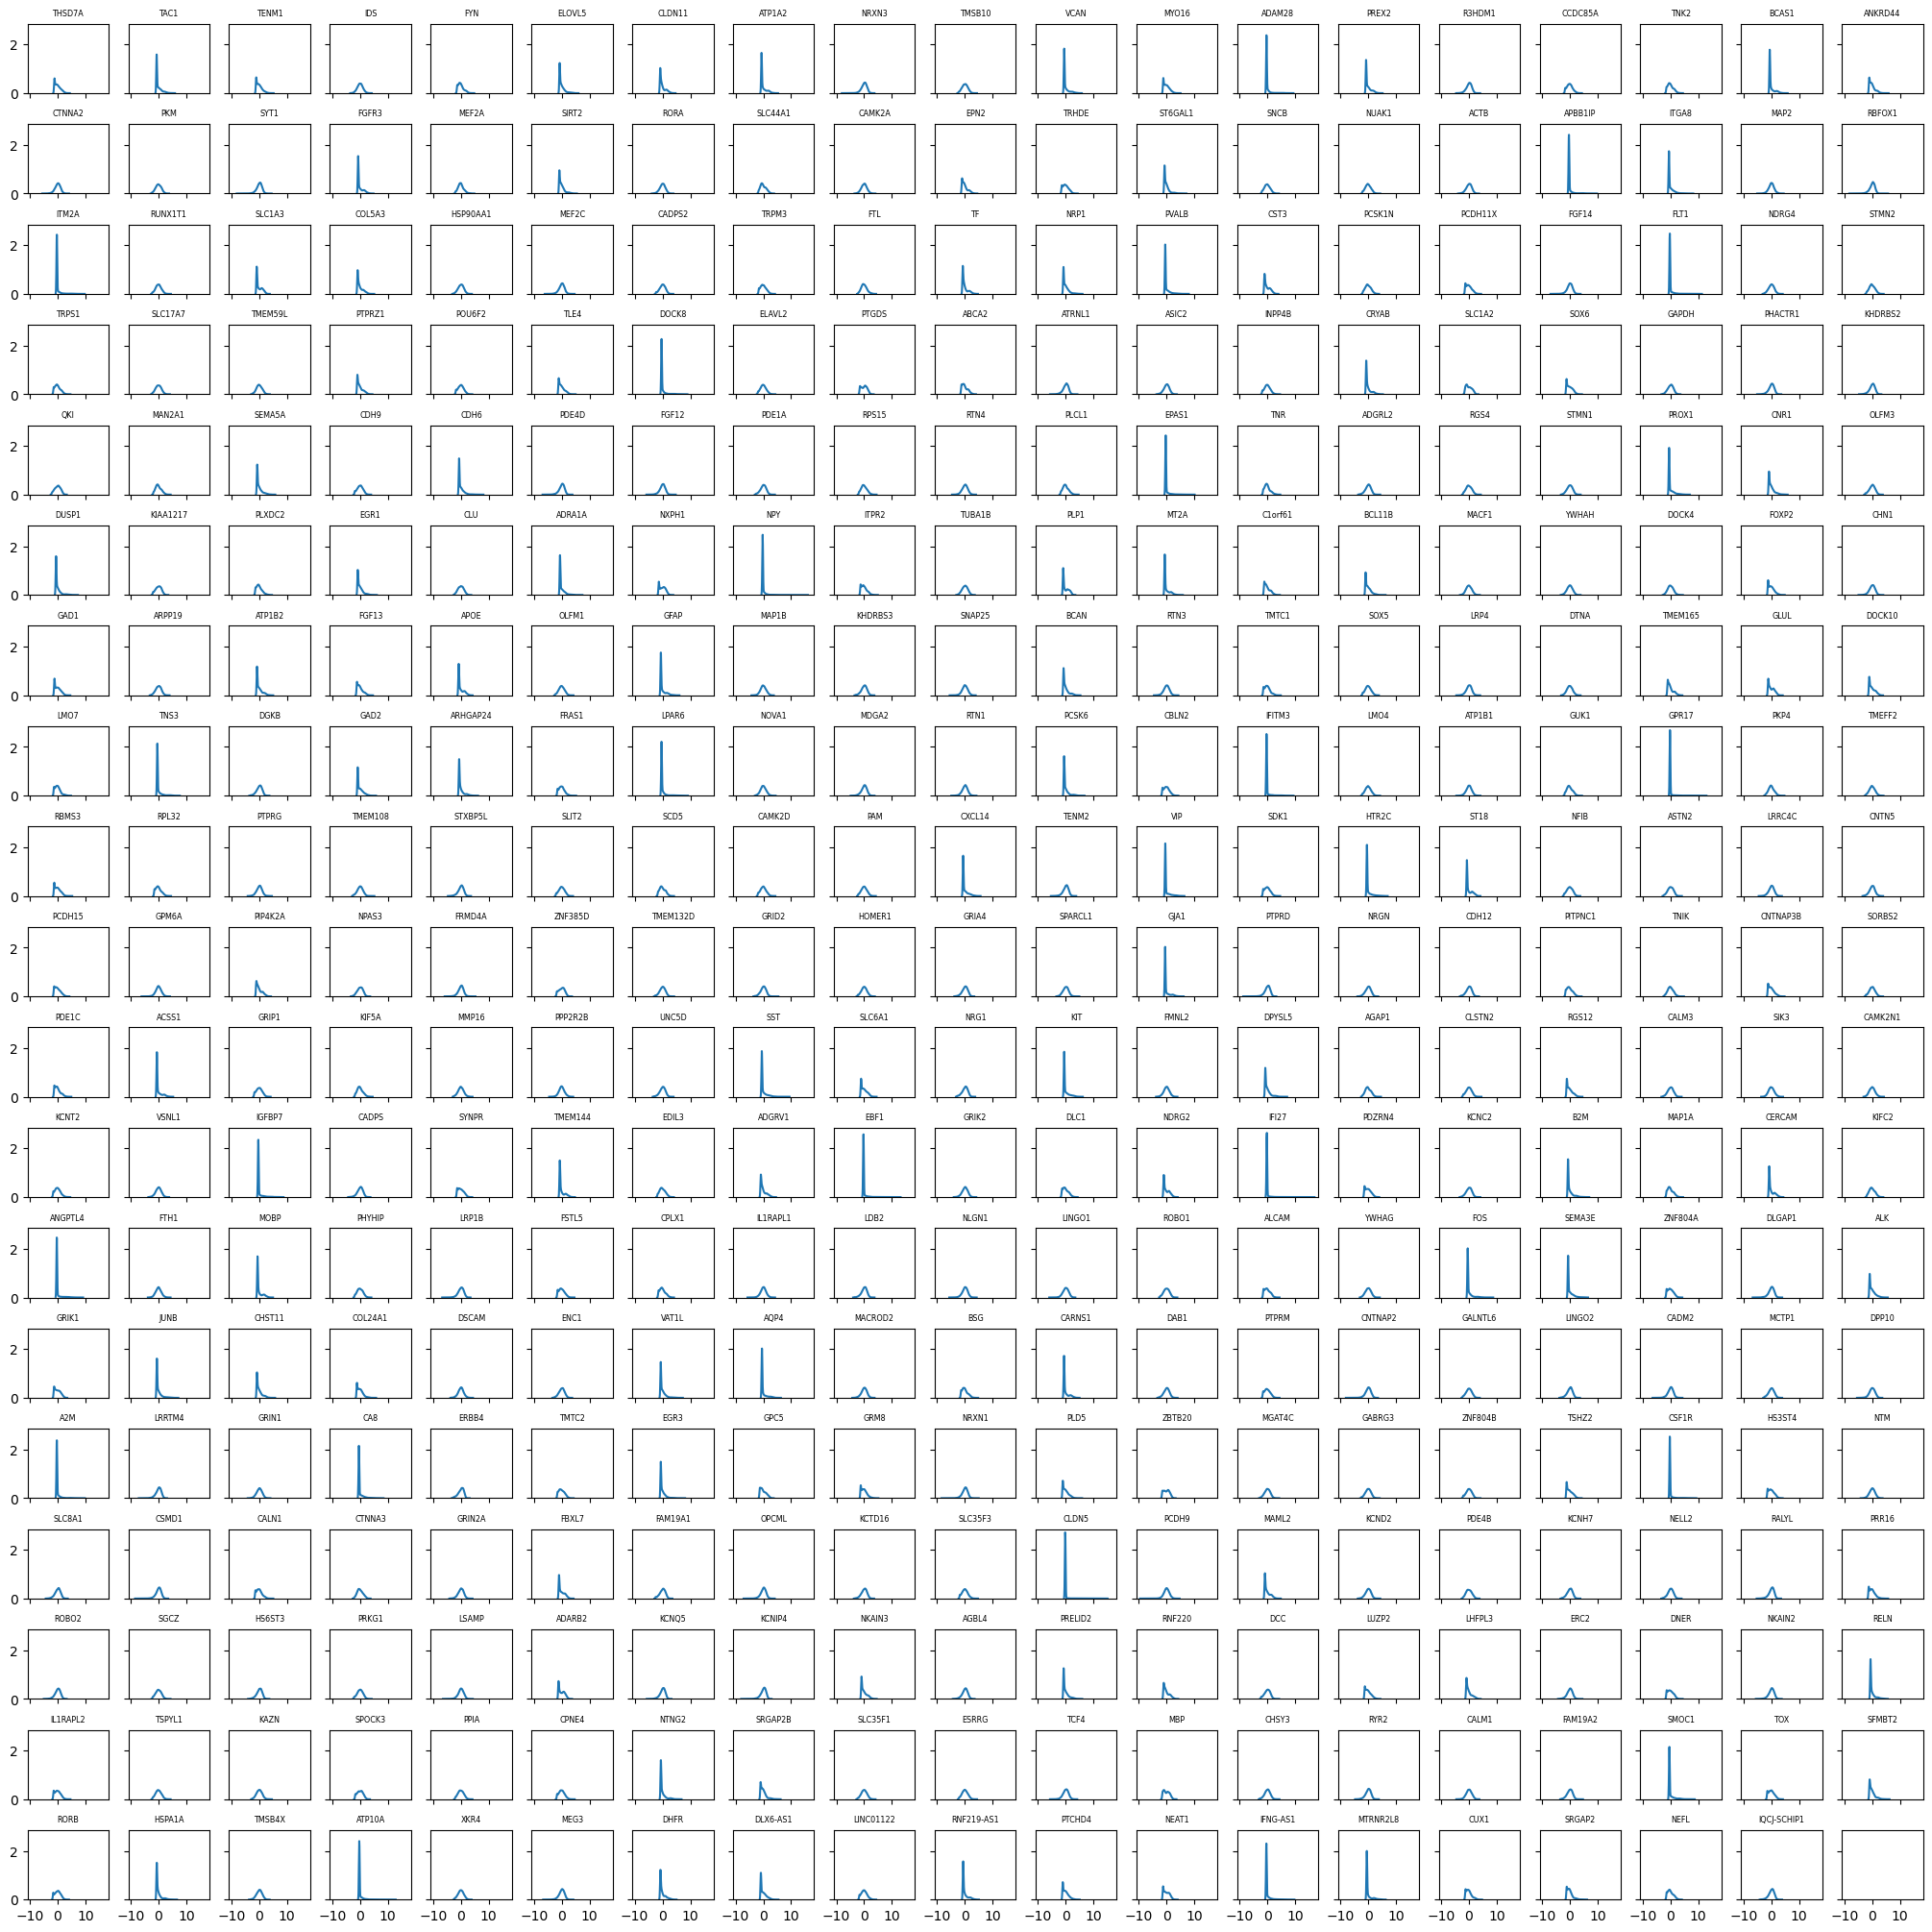

In [7]:
# fig, axs = plt.subplots(19, 19, sharex=True, sharey=True, figsize=(20, 20), constrained_layout=True, dpi=100)

# for i in range(sc_mix_d["train"].shape[1]):

#     sns.kdeplot(x=sc_mix_d["train"][:, i], ax=axs.flatten()[i])
#     axs.flatten()[i].set_title(adata_spatialLIBD.var_names[i], fontsize = 'xx-small')
#     axs.flatten()[i].set_xlabel('')
#     axs.flatten()[i].set_ylabel('')

# plt.show(block=False)


In [5]:
from distfit import distfit

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.02 sec] [RSS: 0.0241207] [loc=0.000 scale=1.000]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.542862] [loc=-9.120 scale=9.120]
[distfit] >[pareto    ] [91.3 sec] [RSS: 0.652689] [loc=-8.716 scale=1.643]
[distfit] >[dweibull  ] [20.1 sec] [RSS: 0.0274547] [loc=0.000 scale=0.836]
[distfit] >[t         ] [25.9 sec] [RSS: 0.0201717] [loc=-0.046 scale=0.870]
[distfit] >[genextreme] [176. sec] [RSS: 0.0136976] [loc=-0.446 scale=0.941]
[distfit] >[gamma     ] [50.2 sec] [RSS: 0.0145401] [loc=-7.730 scale=0.126]
[distfit] >[lognorm   ] [145. sec] [RSS: 0.0126901] [loc=-9.272 scale=9.220]
[distfit] >[beta      ] [143. sec] [RSS: 0.0165449] [loc=-8.309 scale=117.399]
[distfit] >[uniform   ] [0.01 sec] [RSS: 0.518725] [loc=-9.120 scale=25.682]
[distfit] >[loggamma  ] [55.9 sec] [RSS: 0.0259766] [loc=-279.637 scale=38.542]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..


(<Figure size 1000x800 with 1 Axes>,
 <AxesSubplot:title={'center':'\nlognorm\nRSS(s=0.106357, loc=-9.27235, scale=9.21978)'}, xlabel='Values', ylabel='Frequency'>)

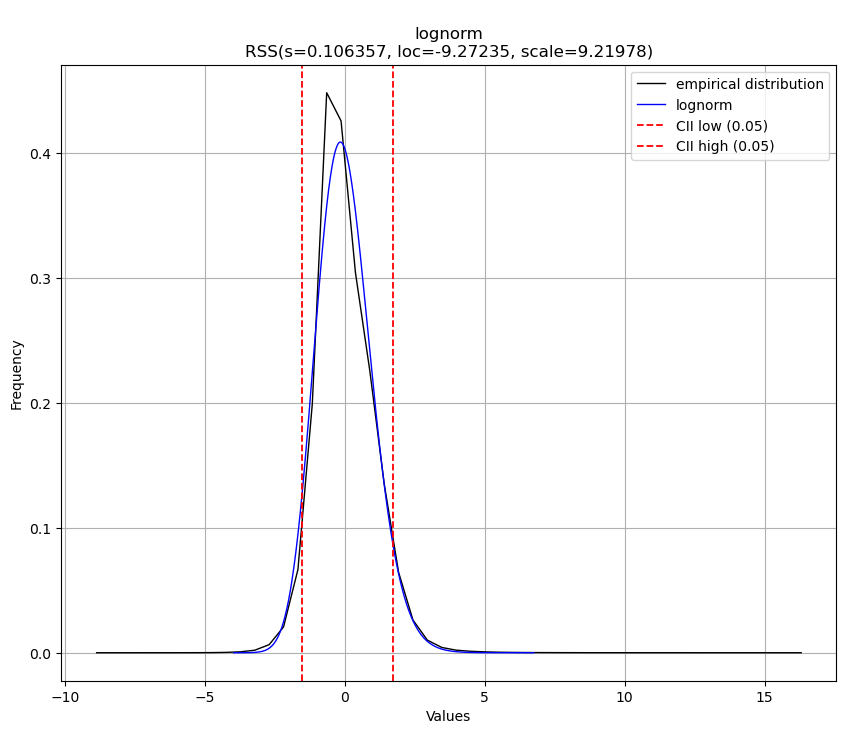

In [6]:
dist = distfit()
results = dist.fit_transform(sc_mix_d["train"].flatten())
dist.plot()

In [11]:
dists = {}
for i in range(sc_mix_d["train"].shape[1]):
    dists[adata_spatialLIBD.var_names[i]] = distfit()
    results = dists[adata_spatialLIBD.var_names[i]].fit_transform(sc_mix_d["train"][:, i], verbose=1)

In [12]:
best_models = {}
for i in range(sc_mix_d["train"].shape[1]):
    best_models[adata_spatialLIBD.var_names[i]] = dists[adata_spatialLIBD.var_names[i]].model["name"]
best_models_df = pd.Series(best_models)
best_models_df.value_counts()


loggamma      114
beta           89
gamma          52
pareto         45
expon          29
t              13
lognorm        12
genextreme      5
norm            1
dtype: int64

In [ ]:

for k, v in mat_sp_d.items():
    v["train"].flatten(), for k, v in mat_sp_d.items()
